<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/Neo4jOpenAIApoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neo4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Integrate LLM workflows with Knowledge Graph using Neo4j and APOC
## OpenAI and VertexAI endpoints are now available as APOC Extended procedures
Probably a day doesn't go by that you don't hear about new and exciting things happening in the Large Language Model (LLM) space. There are so many opportunities and use cases for any company to utilize the power of LLMs to enhance their productivity, transform or manipulate their data, and be used in conversational AI and QA systems.
To make it easier for you to integrate LLMs with Knowledge Graphs, the team at Neo4j has begun the journey of adding support for LLM integrations. The integrations are available as APOC Extended procedures. At the moment, OpenAI and VertexAI endpoints are supported, but we plan to add support for many more.
When I was brainstorming what would be a cool use case to demonstrate the newly added APOC procedures, my friend Michael Hunger suggested an exciting idea. What if we used graph context, or the neighborhood of a node, to enrich the information stored in text embeddings? That way, the vector similarity search could produce better results due to the increased richness of embedded information. The idea is simple but compelling and could be helpful in many use cases.

## Neo4j environment setup
In this example, we will use both the APOC and Graph Data Science libraries. Luckily, Neo4j Sandbox projects have both libraries installed and additionally come with a prepopulated database. Therefore, you can set up the environment with a couple of clicks. We will use [the small Movie project](https://sandbox.neo4j.com/?usecase=movies) to avoid incurring a more considerable LLM API cost.

In [2]:
# Define Neo4j connections
from neo4j import GraphDatabase
host = 'bolt://44.215.124.63:7687'
user = 'neo4j'
password = 'steel-orders-reproduction'
driver = GraphDatabase.driver(host,auth=(user, password))

def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return result.to_df()

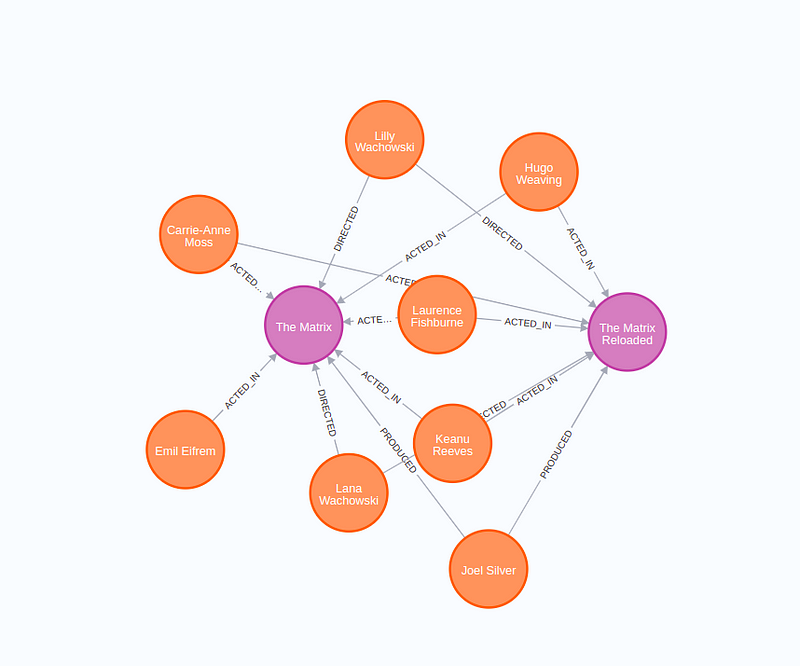

The dataset contains Movie and Person nodes. There are only 38 movies, so we are dealing with a tiny dataset. The information provides a movie's title and tagline, when it was released, and who acted in or directed it.
## Constructing text embedding values

We will be using the OpenAI API endpoints. Therefore, you will end to create an OpenAI account if you haven't already.

As mentioned, the idea is to use the neighborhood of a node to construct its text embedding representation. Since the graph model is simple, we don't have a lot of creative freedom. We will create text embedding representations of movies by using their properties and neighbor information. In this instance, the neighbor information is only about its actors and directors. However, I believe that this concept can be applied to more complex graph schema and be used to improve your vector similarity search applications.



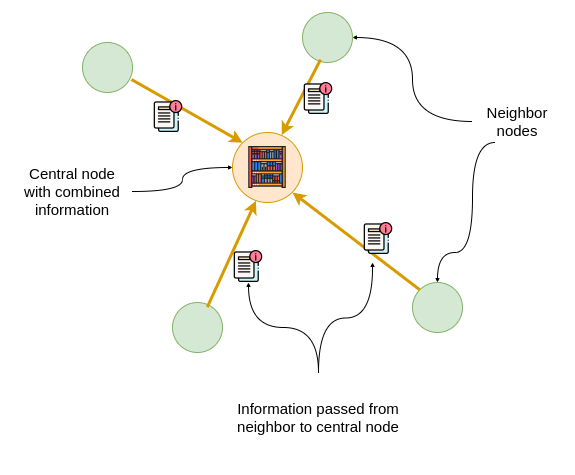

The typical approach we see nowadays, where we simply chunk and embed documents, might fail when looking for information that spans multiple documents. This problem is also known as multi-hop question answering. However, the multi-hop QA problem can be solved using knowledge graphs. One way to look at a knowledge graph is as condensed information storage. For example, an information extraction pipeline can be used to extract relevant information from various records. Using knowledge graphs, you can represent highly-connected information that spans multiple documents as relationships between various entities.

One solution is to use LLMs to generate a Cypher statement that can be used to retrieve connected information from the database. Another solution, which we will use here, is to use the connection information to enrich the text embedding representations. Additionally, the enhanced information can be retrieved at query time to provide additional context to the LLM from which it can base its response.

The following Cypher query can be used to retrieve all the relevant information about the movie nodes from their neighbors.

In [3]:
print(run_query("""
MATCH (m:Movie)
MATCH (m)-[r:ACTED_IN|DIRECTED]-(t)
WITH m, type(r) as type, collect(t.name) as names
WITH m, type+": "+reduce(s="", n IN names | s + n + ", ") as types
WITH m, collect(types) as contexts
WITH m, "Movie title: "+ m.title + " year: "+coalesce(m.released,"") +" plot: "+ coalesce(m.tagline,"")+"\n" +
       reduce(s="", c in contexts | s + substring(c, 0, size(c)-2) +"\n") as context
RETURN context LIMIT 1
""")['context'][0])

Movie title: The Matrix year: 1999 plot: Welcome to the Real World
ACTED_IN: Emil Eifrem, Hugo Weaving, Laurence Fishburne, Carrie-Anne Moss, Keanu Reeves
DIRECTED: Lana Wachowski, Lilly Wachowski



Depending on your domain, you might also use custom queries that retrieve information more than one hop away or sometimes want to aggregate some results.

We will now use OpenAI's embedding endpoint to generate text embeddings representing the movies and their context and store them as node properties.

In [4]:
openai_api_key = "OPENAI_API_KEY"

In [5]:
run_query("""
CALL apoc.periodic.iterate(
  'MATCH (m:Movie) RETURN id(m) AS id',
  'MATCH (m:Movie)
   WHERE id(m) = id
   MATCH (m)-[r:ACTED_IN|DIRECTED]-(t)
   WITH m, type(r) as type, collect(t.name) as names
   WITH m, type+": "+reduce(s="", n IN names | s + n + ", ") as types
   WITH m, collect(types) as contexts
   WITH m, "Movie title: "+ m.title + " year: "+coalesce(m.released,"") +" plot: "+ coalesce(m.tagline,"")+"\n" +
        reduce(s="", c in contexts | s + substring(c, 0, size(c)-2) +"\n") as context
   CALL apoc.ml.openai.embedding([context], $apiKey) YIELD embedding
   SET m.embedding = embedding',
  {batchSize:1, retries:3, params: {apiKey: $apiKey}})
""", {'apiKey': openai_api_key})['errorMessages'][0]

{}

The newly added apoc.ml.openai.embeddingprocedures make generating text embeddings very easy using OpenAI's API. We wrap the API call with apoc.periodic.iterate to batch the transactions and introduce the retry policy.

# Retrieval-augmented LLMs

It looks like the mainstream trend is to provide LLMs with external information at query time. We can even find OpenAI's guides how to provide relevant information as part of the prompt to generate the answer.

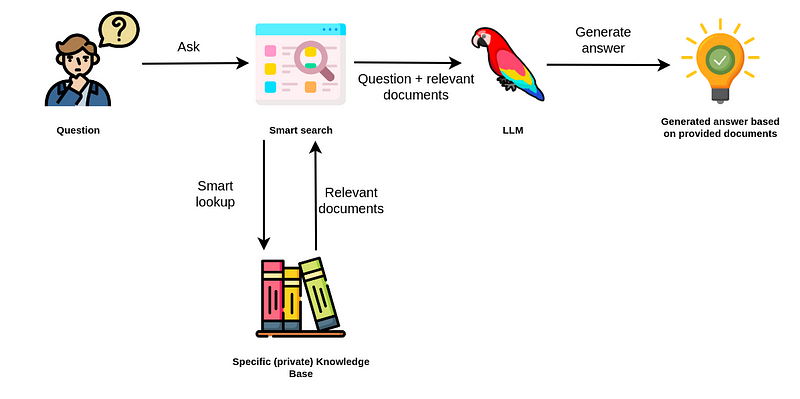

Here, we will use vector similarity search to find relevant movies given the user input. The workflow is the following:
We embed the user question with the same text embedding model we used to embed node context information
We use the cosine similarity to find the top 3 most relevant nodes and return their information to the LLM
The LLM constructs the final answer based on the provided information

Since we will be using the gpt-3.5-turbo model to generate the final answer, it is a good practice to define the system prompt. To make it more readable, we will define the system prompt as Python variable and then use query parameters when executing Cypher statements.


In [6]:
system_prompt = """
You are an assistant that helps to generate text to form nice and human understandable answers based.
The latest prompt contains the information, and you need to generate a human readable response based on the given information.
Make the answer sound as a response to the question. Do not mention that you based the result on the given information.
Do not add any additional information that is not explicitly provided in the latest prompt.
I repeat, do not add any information that is not explicitly given.
"""

Next, we will define a function that constructs a user prompt based on the user question and the provided context from the database.

In [7]:
def generate_user_prompt(question, context):
    return f"""
   The question is {question}
   Answer the question by using the provided information:
   {context}
   """

Before asking the LLM to generate answers, we must define the intelligent search tool that will provide relevant context information based on the vector similarity search. As mentioned, we need to embed the user input and then use the cosine similarity to identify relevant nodes. With graphs, you can decide the type of information you want to retrieve and provide as context. In this example, we will return the same context information that was used to generate text embeddings along with similar movie information.

In [8]:
def retrieve_context(question, k=3):
    data = run_query(
        """
    // retrieve the embedding of the question
    CALL apoc.ml.openai.embedding([$question], $apiKey) YIELD embedding
    // match relevant movies
    MATCH (m:Movie)
    WITH m, gds.similarity.cosine(embedding, m.embedding) AS score
    ORDER BY score DESC
    // limit the number of relevant documents
    LIMIT toInteger($k)
    // retrieve graph context
    MATCH (m)--()--(m1:Movie)
    WITH m,m1, count(*) AS count
    ORDER BY count DESC
    WITH m, apoc.text.join(collect(m1.title)[..3], ", ") AS similarMovies
    MATCH (m)-[r:ACTED_IN|DIRECTED]-(t)
    WITH m, similarMovies, type(r) as type, collect(t.name) as names
    WITH m, similarMovies, type+": "+reduce(s="", n IN names | s + n + ", ") as types
    WITH m, similarMovies, collect(types) as contexts
    WITH m, "Movie title: "+ m.title + " year: "+coalesce(m.released,"") +" plot: "+ coalesce(m.tagline,"")+"\n" +
          reduce(s="", c in contexts | s + substring(c, 0, size(c)-2) +"\n") + "similar movies:" + similarMovies + "\n" as context
    RETURN context
  """,
        {"question": question, "k": k, "apiKey": openai_api_key},
    )
    return data["context"].to_list()

At the moment, you need to use the gds.similarity.cosine function to calculate the cosine similarity between the question and relevant nodes. After identifying the relevant nodes, we retrieve the context using two additional MATCHclauses. You can check out Neo4j's GraphAcademy to learn more about Cypher query language.

Finally, we can define the function that takes in the user question and returns an answer.

In [9]:
def generate_answer(question):
    # Retrieve context
    context = retrieve_context(question)
    # Print context
    for c in context:
        print(c)
    # Generate answer
    response = run_query(
        """
  CALL apoc.ml.openai.chat([{role:'system', content: $system},
                      {role: 'user', content: $user}], $apiKey) YIELD value
  RETURN value.choices[0].message.content AS answer
  """,
        {
            "system": system_prompt,
            "user": generate_user_prompt(question, context),
            "apiKey": openai_api_key,
        },
    )
    return response["answer"][0]

Let's test our retrieval-augmented LLM workflow.

In [10]:
generate_answer("Who played in the Matrix?")

Movie title: The Matrix year: 1999 plot: Welcome to the Real World
ACTED_IN: Emil Eifrem, Hugo Weaving, Laurence Fishburne, Carrie-Anne Moss, Keanu Reeves
DIRECTED: Lana Wachowski, Lilly Wachowski
similar movies:The Matrix Revolutions, The Matrix Reloaded, V for Vendetta

Movie title: The Matrix Reloaded year: 2003 plot: Free your mind
DIRECTED: Lana Wachowski, Lilly Wachowski
ACTED_IN: Hugo Weaving, Laurence Fishburne, Carrie-Anne Moss, Keanu Reeves
similar movies:The Matrix Revolutions, The Matrix, V for Vendetta

Movie title: The Matrix Revolutions year: 2003 plot: Everything that has a beginning has an end
DIRECTED: Lana Wachowski, Lilly Wachowski
ACTED_IN: Hugo Weaving, Laurence Fishburne, Carrie-Anne Moss, Keanu Reeves
similar movies:The Matrix Reloaded, The Matrix, V for Vendetta



'The actors who played in The Matrix are Emil Eifrem, Hugo Weaving, Laurence Fishburne, Carrie-Anne Moss and Keanu Reeves.'

In [11]:
generate_answer("Recommend a movie with Jack Nicholson?")

Movie title: Something's Gotta Give year: 2003 plot: 
ACTED_IN: Keanu Reeves, Diane Keaton, Jack Nicholson
DIRECTED: Nancy Meyers
similar movies:Something's Gotta Give, The Replacements, Johnny Mnemonic

Movie title: One Flew Over the Cuckoo's Nest year: 1975 plot: If he's crazy, what does that make you?
ACTED_IN: Danny DeVito, Jack Nicholson
DIRECTED: Milos Forman
similar movies:Hoffa, As Good as It Gets, Something's Gotta Give

Movie title: As Good as It Gets year: 1997 plot: A comedy from the heart that goes for the throat.
ACTED_IN: Helen Hunt, Jack Nicholson, Cuba Gooding Jr., Greg Kinnear
DIRECTED: James L. Brooks
similar movies:A Few Good Men, Cast Away, Twister



'If you\'re looking for a movie recommendation featuring Jack Nicholson, I\'d suggest checking out "One Flew Over the Cuckoo\'s Nest" from 1975. The movie stars Danny DeVito and Jack Nicholson, and was directed by Milos Forman. It\'s a classic drama that portrays the struggles of patients in a mental institution.'

In [13]:
generate_answer("What are similar movies to As Good as It Gets?")

Movie title: Something's Gotta Give year: 2003 plot: 
ACTED_IN: Keanu Reeves, Diane Keaton, Jack Nicholson
DIRECTED: Nancy Meyers
similar movies:Something's Gotta Give, The Replacements, Johnny Mnemonic

Movie title: As Good as It Gets year: 1997 plot: A comedy from the heart that goes for the throat.
ACTED_IN: Helen Hunt, Jack Nicholson, Cuba Gooding Jr., Greg Kinnear
DIRECTED: James L. Brooks
similar movies:A Few Good Men, Cast Away, Twister

Movie title: The Devil's Advocate year: 1997 plot: Evil has its winning ways
DIRECTED: Taylor Hackford
ACTED_IN: Al Pacino, Charlize Theron, Keanu Reeves
similar movies:That Thing You Do, Something's Gotta Give, The Replacements



'There are a few similar movies to "As Good as It Gets" that you may enjoy. If you liked the combination of comedy and drama in the plot, you may also enjoy "A Few Good Men" and "Cast Away". If you enjoyed the acting of Jack Nicholson, you might also like "The Replacements" and "Johnny Mnemonic", both of which he had a role in.'

## Summary
And there you have it, a glimpse into the fascinating world of integrating Large Language Models with Knowledge Graphs. As the field continues to evolve, so too will the tools and techniques at our disposal. With Neo4j and APOC's continued advancements, we can expect even greater innovation in how we handle and process data.